In [1]:
import pandas as pd 

# Load the CSV
df = pd.read_csv('../raw_data/example_data.csv')

print df.columns
print 
print df.head(10)


Index([u'Unnamed: 0', u'datetime', u'snowdepth_1', u'snowdepth_2',
       u'snowdepth_3', u'snowdepth_4', u'snowdepth_5', u'snowdepth_6',
       u'snowdepth_7', u'snowdepth_8', u'snowdepth_9', u'snowdepth_10'],
      dtype='object')

   Unnamed: 0             datetime  snowdepth_1  snowdepth_2  snowdepth_3  \
0           0  2015-10-01 00:00:00       4146.0       4017.0       4046.0   
1           1  2015-10-01 00:15:00       4144.0       4013.0       4053.0   
2           2  2015-10-01 00:30:00       4153.0       4015.0       4046.0   
3           3  2015-10-01 00:45:00       4144.0       4015.0       4047.0   
4           4  2015-10-01 01:00:00       4147.0       4017.0       4047.0   
5           5  2015-10-01 01:15:00       4146.0       4014.0       4042.0   
6           6  2015-10-01 01:30:00       4151.0       4017.0       4039.0   
7           7  2015-10-01 01:45:00       4145.0       4015.0       4061.0   
8           8  2015-10-01 02:00:00       4144.0       4012.0       4059.0

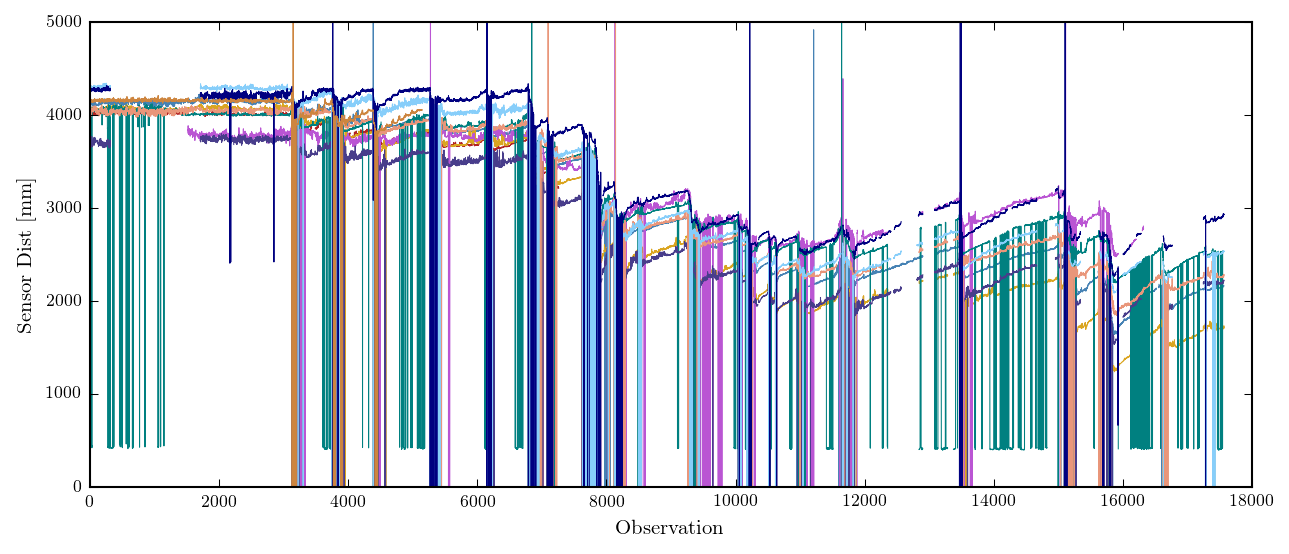

In [2]:
# Plot all the time series. 

plt.figure(figsize=(10,4))
for i in range(1,11):
    
    plt.plot(df['snowdepth_%i'%i].values, linewidth=.5)
    
plt.ylim(0,5000)
plt.ylabel('Sensor Dist [mm]')
plt.xlabel('Observation')

This data is plagued by outliers.  Fortunately, the outlier deviation is well above the noise level.  We construct a simple outlier detection filter based on a moving median and median absolute deviation, which will be muh more robust than a mean squared error and variance filter.  For a window size $n$, an observation's outlier statistic is the modified z-score, 

$$ z(x_i) = \frac{ |x_i-{\rm med}_i(x_i)|}{{\rm med_j}(|x_j-{\rm med}_i(x_i)|)}$$ 

for $j\in (i-n/2) ... (i+n/2) $ and where med_i is the median of the argument over the index i.

Our outlier detection algorithm then as two parameters: the window size $n$ and the threshold for the modified z-score.  We then set the outliers to NaN. 





In [3]:

def GetMAD_Obs(i, x, window_size):
    '''
    Return the median abosolute deviation of an observation i over a moving window. 
    
    Parameters
    ----------
    i : int
        observation index
    x : 1D array
        observation list
    window_size: int
        how many observations are included on each side of the target observation. 
    
    
    Returns
    -------
    MAD : int
        Modified z-score in median abosolute deviations.
    '''
    x = np.asarray(x)
    
    # If our observation is an NaN, just return NaN
    if np.isnan(x[i]):
        return x[i]
        
    n_obs = x.shape[0]
    
    start_i = np.max( (0,i - window_size) ) # Don't let start i go negative 
    end_i = np.min( (i + window_size, n_obs) ) # i < n_obs 
    
    # We also need to remove NaN values to compute the median 
    obs_set = x[start_i:end_i][np.logical_not(np.isnan(x[start_i:end_i]))]
        
    median = np.median( obs_set )
    MAD = np.median( np.abs((obs_set-median)) )
    mod_z_score = np.abs(x[i]-median)/MAD    
    
    return mod_z_score


from multiprocessing import pool 
from functools import partial 

def GetMad(x, window_size, threshold):
    '''
    Return the median abosolute deviation of an observation list over a moving window. 
    
    Parameters
    ----------
    x : 1D array
        observation list
    window_size: int
        how many observations are included on each side of the target observation. 
    threshold: float
        what is the modified z-score threshold for outliers 
    
    Returns
    -------
    MAD : float array 
        Modified z-score in median abosolute deviations.
    '''
    # Multithreaded because, why not?
    p = pool.Pool()
    func = partial(GetMAD_Obs, x=x, window_size=window_size ) 
    mod_z = np.array(p.map(func, range(len(x))))
    p.close()
    
#     plt.plot(mod_z)
#     plt.show()
    
    new_obs = x.copy()
    new_obs[mod_z>threshold] = np.nan # set outliers to NaN
    return new_obs
        


### Now let's run the algorithm on each sensor's time series.  We also plot the original data in transparent blue.

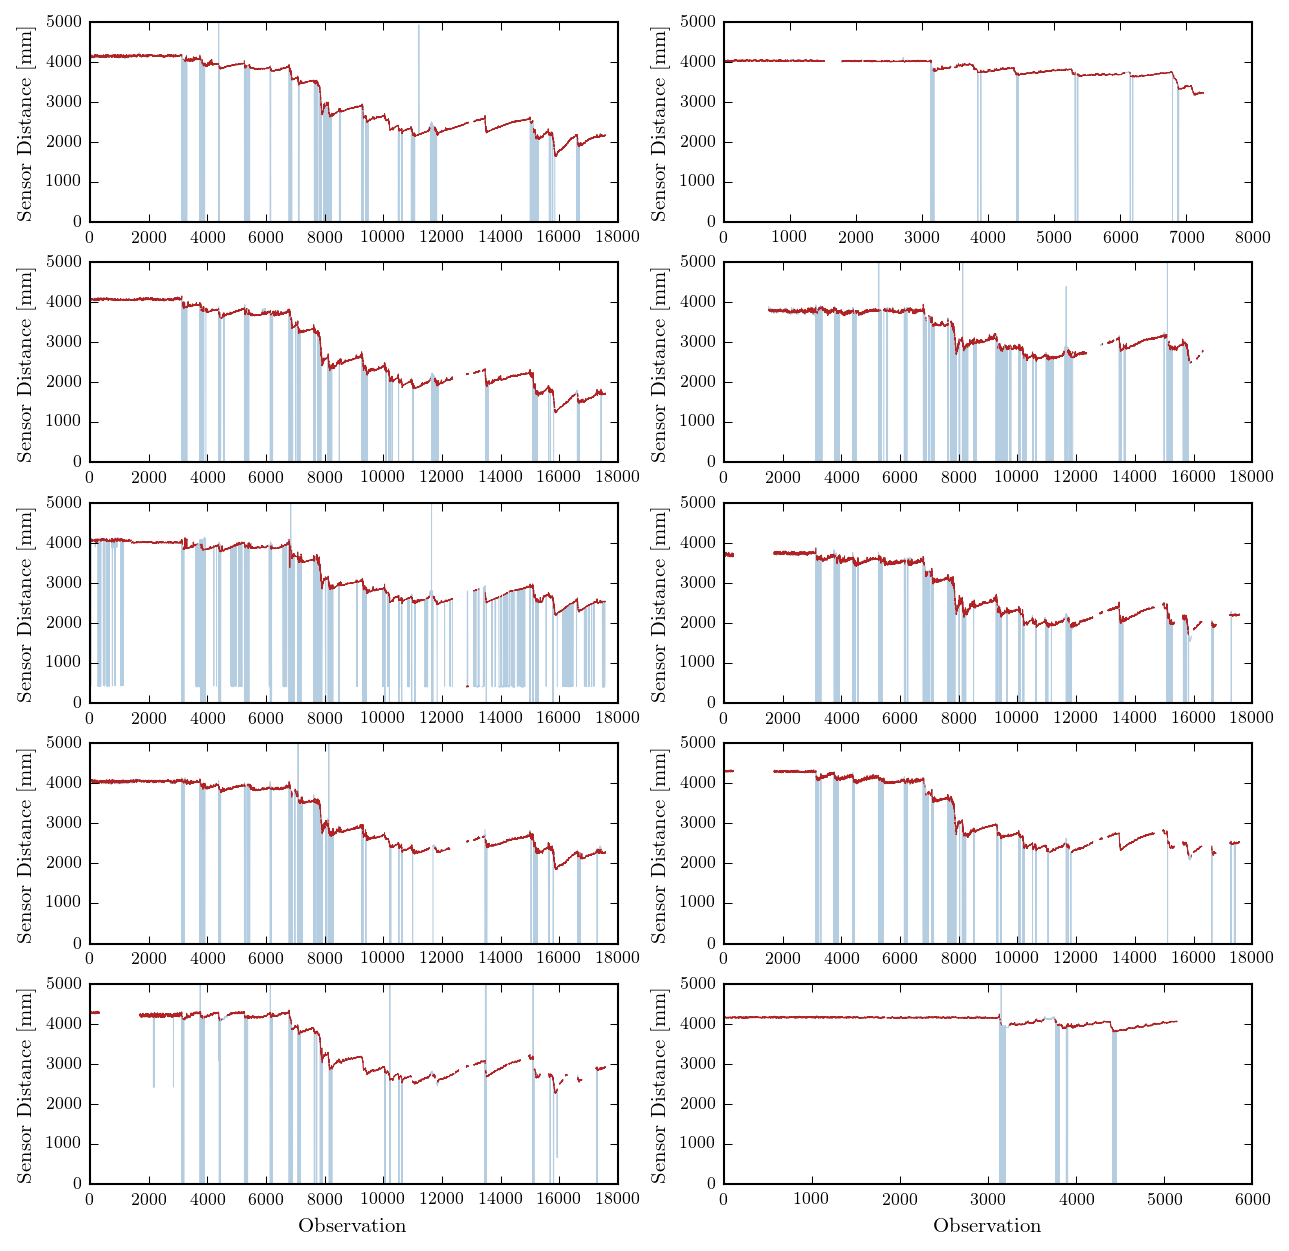

In [4]:
plt.figure(figsize=(10,10))
df_clean = df.copy()

for i in range(1,11):    
    plt.subplot(5,2,i)
    cleaned = GetMad(df['snowdepth_%i'%i].values[:], window_size=500, threshold=3)
    plt.plot(df['snowdepth_%i'%i].values, linewidth=.5, alpha=.4)
    df_clean['snowdepth_%i'%i] = cleaned
    plt.plot(df_clean['snowdepth_%i'%i], linewidth=.5)
    
    plt.ylim(0,5000)
    plt.ylabel('Sensor Distance [mm]')
    if i>8:
        plt.xlabel('Observation')

### Just to compute some basic statistics, lets fill in missing values with linear interpolation from the sides.  We then plot the original (cleaned) case and the interpolated case.  Later, these missing values will be filled via multiple prediction from our Kalman filter. 

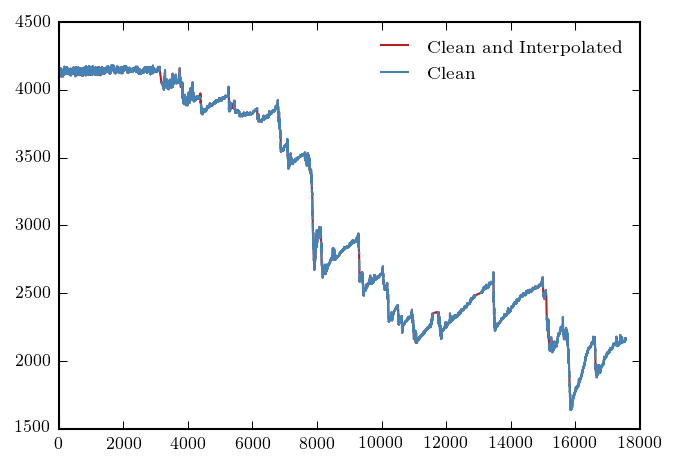

In [5]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]


def InterpolateNaNs(y):
    """Fill missing values with interpolation 

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - new, interpolated array
    """
    nans, x= nan_helper(y)
    new = y.copy()
    new[nans] = np.interp(x(nans), x(~nans), y[~nans])
    return new

df_clean_filled = df_clean.copy()
for i in range(1,11):
    df_clean_filled['snowdepth_%i'%i] = InterpolateNaNs(df_clean_filled['snowdepth_%i'%i])
    


plt.plot(df_clean_filled['snowdepth_1']-0, label='Clean and Interpolated', alpha=1, color='firebrick')
plt.plot(df_clean['snowdepth_1'], label='Clean', color='steelblue')

df_clean.to_pickle('../output/cluster_0_cleaned.pickle')

plt.legend(frameon=False)


### The dataset is now relatively clean, so let's look at auto and cross-correlations...

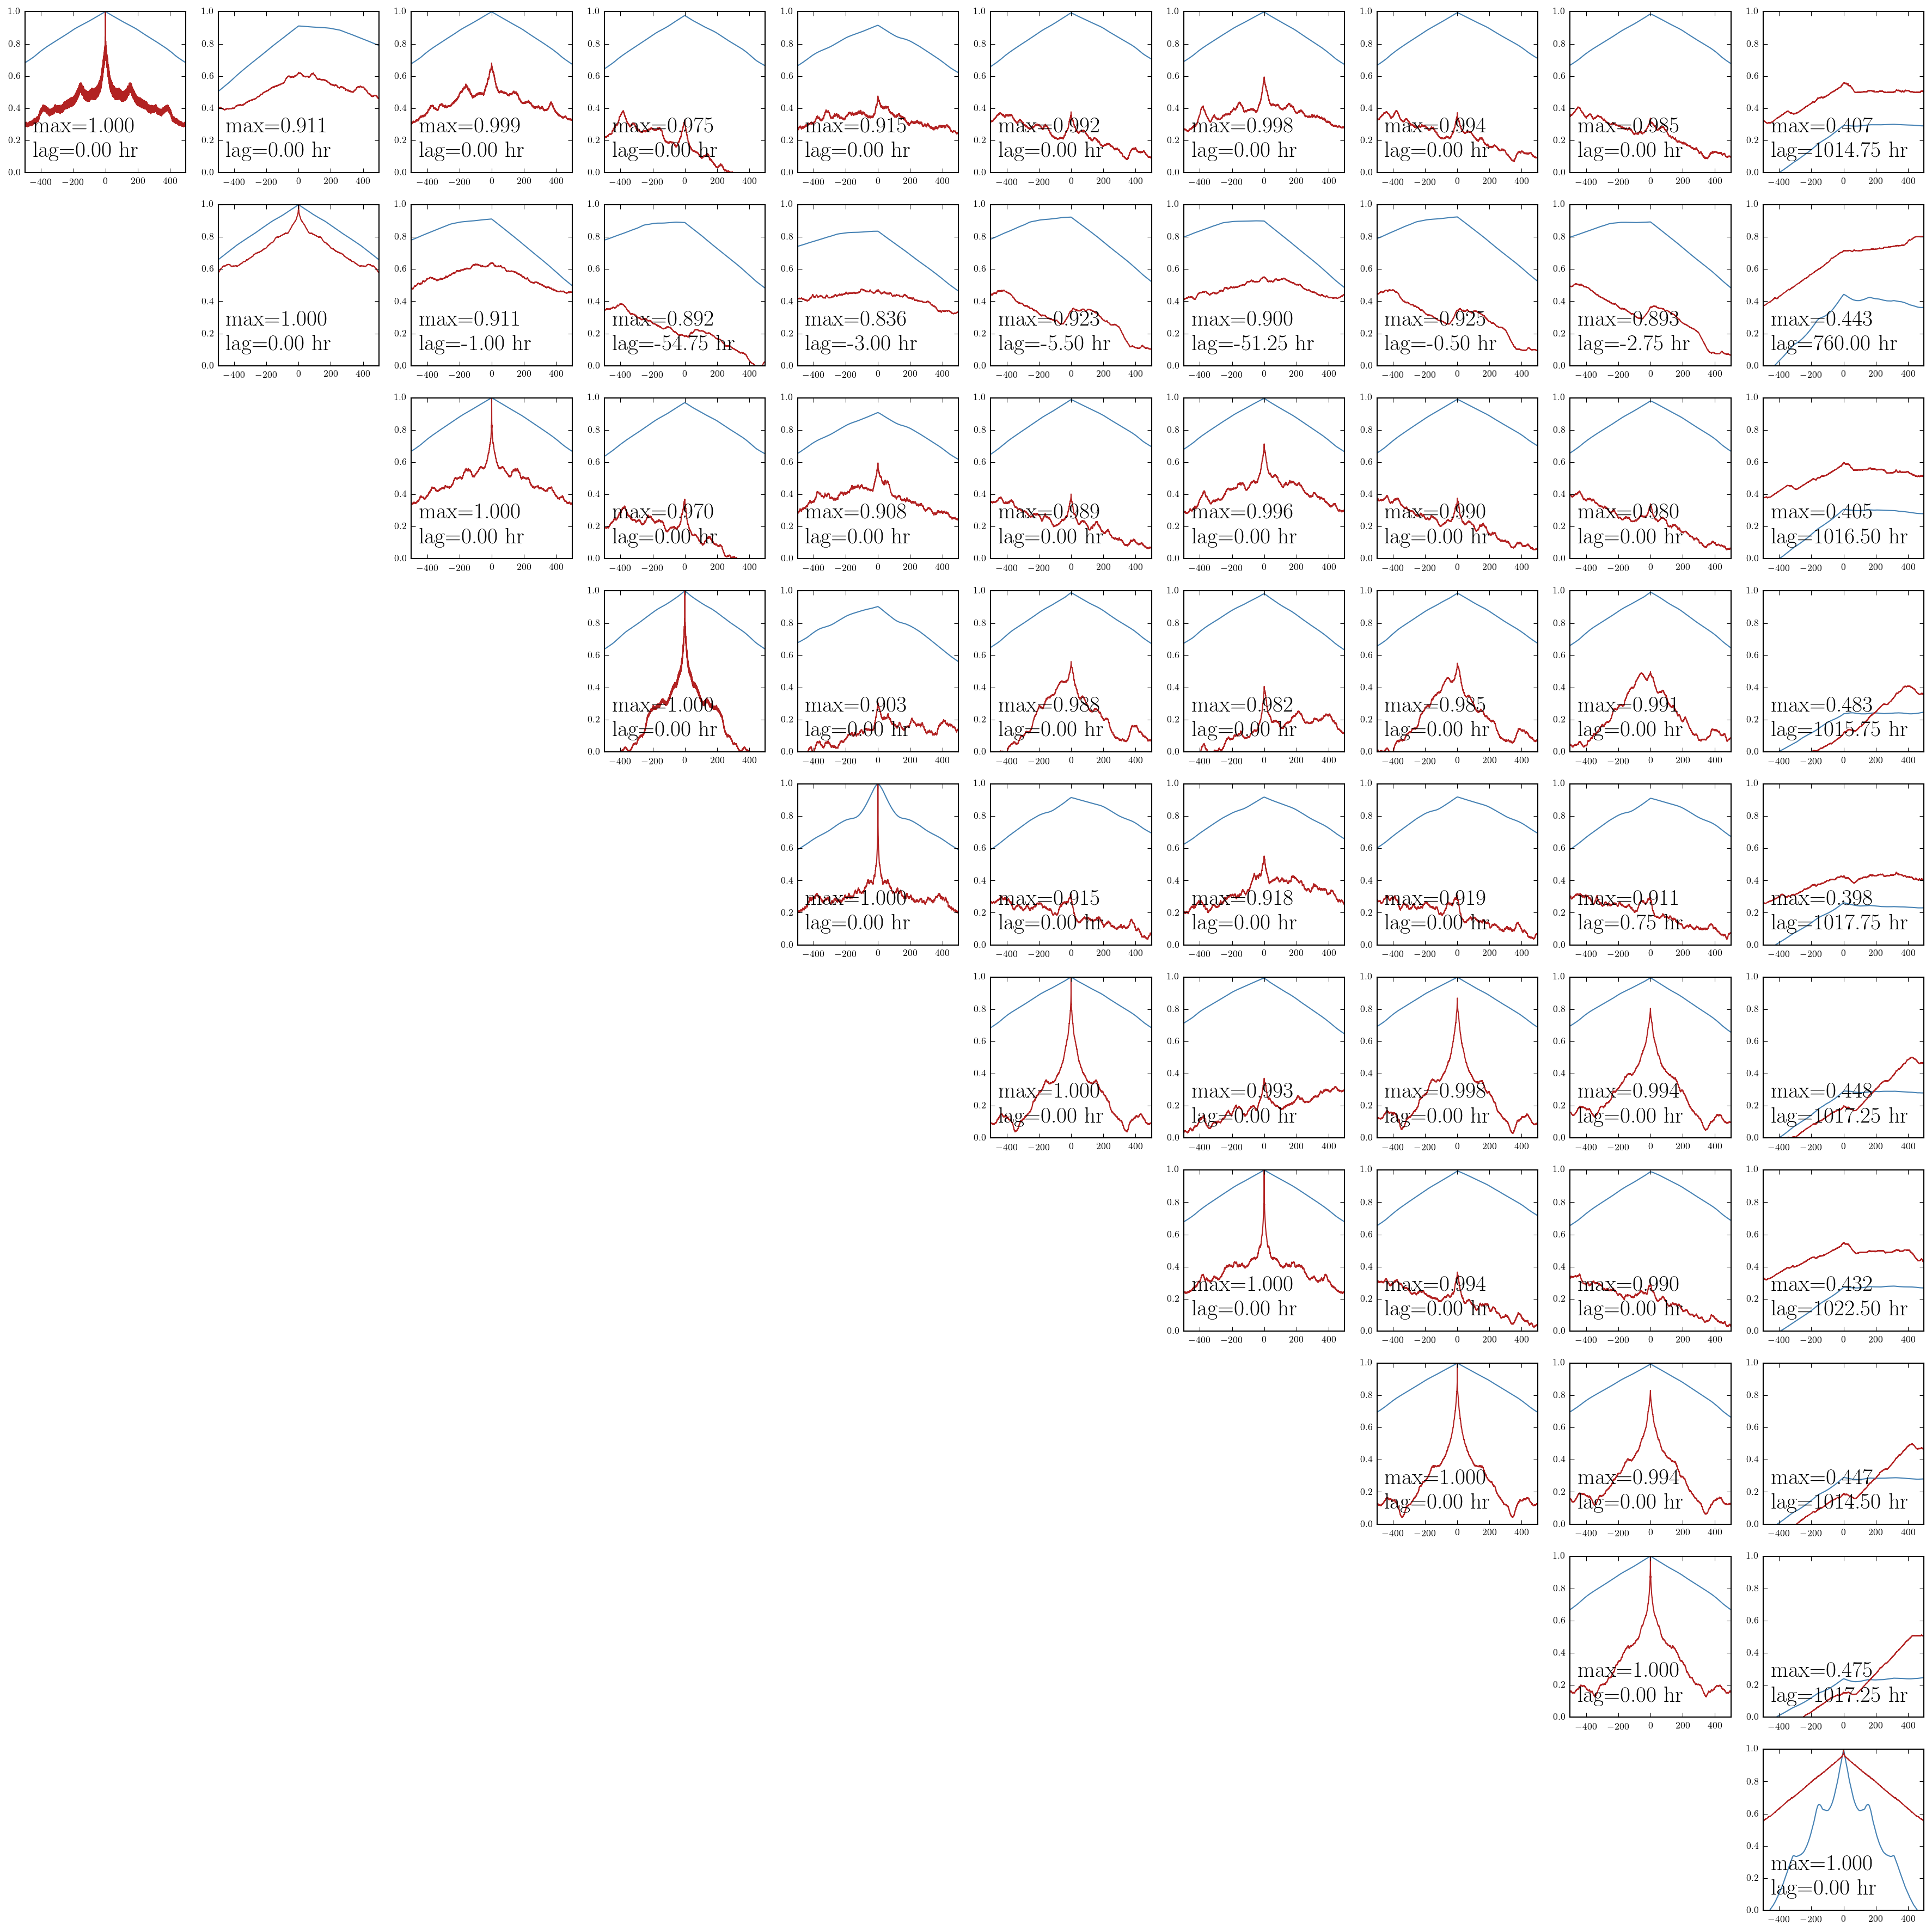

In [6]:
from scipy import signal 

plt.figure(figsize=(30,30))
for i in range(1,11):
    for j in range(i,11):
        set1 = df_clean_filled['snowdepth_%i'%i].values
        set2 = df_clean_filled['snowdepth_%i'%j].values
        
        set1_no_clean = np.nan_to_num(df['snowdepth_%i'%i].values)
        set2_no_clean = np.nan_to_num(df['snowdepth_%i'%j].values)
        
        # Normalize the input vectors 
        a = (set1 - mean(set1)) / (std(set1) * len(set1))
        v = (set2 - mean(set2)) /  std(set2)
        
        corr = signal.correlate(a, v, mode='same')
        max_corr = np.max(corr)  # Find maximal correlation 
        max_corr_position = np.argmax(corr)-len(a)/2 # Find time lag for maximial cross-correlation
        
        a_no_clean = (set1_no_clean - mean(set1_no_clean)) / (std(set1_no_clean) * len(set1_no_clean))
        v_no_clean = (set2_no_clean - mean(set2_no_clean)) /  std(set2_no_clean)
        
        corr_no_clean = signal.correlate(a_no_clean, v_no_clean, mode='same')
        max_corr_no_clean = np.max(corr_no_clean)  # Find maximal correlation 
            
        # Plotting 
        plt.subplot2grid((10,10),(i-1, j-1))
        plt.plot((np.arange(len(corr))-len(a)/2.)/4., corr)
        plt.plot((np.arange(len(corr_no_clean))-len(a_no_clean)/2.)/4., corr_no_clean, color='firebrick', linestyle='-')
        plt.xlim(-500, 500)
        plt.vlines(len(a)/2, 0, 1, linestyle='--', alpha=.4)
        
        plt.text(.05, .25, 'max=%1.3f'%max_corr, transform=plt.gca().transAxes, fontsize=20)
        plt.text(.05, .1, 'lag=%1.2f hr'%(max_corr_position/4.), transform=plt.gca().transAxes, fontsize=20)
        plt.ylim(0,1)
        

We see from the above that the sensors are very highly correlated at zero time-lag.  Using the correlation and lag (time shift to maximal cross-correlation), we have (i) a powerful way to find faulty sensors, and (ii) a correlation coefficient which may be useful as input into our Kalman filter process model. 

It is obvious here, for example, that sensor 10 is failing, or improperly placed.  

We are also not limited to this sensor cluster alone and can use a similar methods to detect correlated sensors from other nearby clusters. 


In order to get a handle on the noise characteristics, lets decompse the time series, and look at correlations across frequecny windows.  Hopefully, there is a clear frequency above which the correlation coefficient drops to approximately zero, representing white noise.



In [62]:
def FFT_High_Pass(x, low_freq_cutoff, plot=False, low_pass=False):
    """Run a signal through a high-pass filter.  Timestep is assumed 15 s 
    
    Input:
        - x: 1d numpy array with input signal
        - low_freq_cutoff: Frequency cut in inverse hours
        - plot: If True, plot the power spectrum 
        - low_pass: if True, run a low pass filter instead of high pass. 
    Output:
        - signal: The processed signal 
    """
    
    fft_coeff = np.fft.fft(x)
    freq = np.fft.fftfreq(len(x), .25)
    power = fft_coeff*np.conjugate(fft_coeff)
    
    cutoff_index = np.argmin( np.abs(low_freq_cutoff-freq) )
    if low_pass == False:
        fft_coeff[:cutoff_index] = 0 
    else: 
        fft_coeff[cutoff_index:] = 0 
    
    bandpassed_signal = np.fft.ifft(fft_coeff).real
    
    if plot:
        power_filtered = fft_coeff*np.conjugate(fft_coeff)
        plt.loglog(freq, power)
        plt.loglog(freq, power_filtered)
        plt.xlabel('Frequency [Hr$^{-1}$]')
        plt.ylabel(r'Power Spectrum $\langle a_i|a_i \rangle$')
        plt.show()
    
    return bandpassed_signal 


def FFT_Band_Pass(x, freq_range, plot=False):
    """Run a signal through a Band-pass filter.  Timestep is assumed 15 s 
    
    Input:
        - x: 1d numpy array with input signal
        - freq_range: Tuple
            Frequency range in inverse hours
        - plot: If True, plot the power spectrum 
    Output:
        - signal: The processed signal 
    """
    
    fft_coeff = np.fft.fft(x)
    freq = np.fft.fftfreq(len(x), .25)
    power = fft_coeff*np.conjugate(fft_coeff)
    
    cutoff_index_low = np.argmin( np.abs(freq_range[0]-freq) )
    cutoff_index_high = np.argmin( np.abs(freq_range[1]-freq) )

    fft_coeff[:cutoff_index_low] = 0 
    fft_coeff[cutoff_index_high:] = 0 
    
    bandpassed_signal = np.fft.ifft(fft_coeff).real
    
    if plot:
        power_filtered = fft_coeff*np.conjugate(fft_coeff)
        plt.loglog(freq, power)
        plt.loglog(freq, power_filtered)
        plt.xlabel('Frequency [Hr$^{-1}$]')
        plt.ylabel(r'Power Spectrum $\langle a_i|a_i \rangle$')
        plt.show()
    
    return bandpassed_signal 

def High_Pass_Cross_Correlation(x, y):
    """For two input signals we run each through a high-pass filter and calculate the cross-correlation, scanning over frequencies. 
    
    Input:
        - x: 1d numpy array with input signal 1 
        - y: 1d numpy array with input signal 2 
    Output:
        - scan_frequencies: 1d array with frequencies in Hr^-1
        - cross_correlation: normalized maximal cross-correlation coefficient 
    """
    scan_frequencies = np.logspace(-2,np.log10(2),10)
    
    xcorr = []
    for i_freq, scan_freq in enumerate(scan_frequencies[:-1]):
        freq_range = [scan_frequencies[i_freq], scan_frequencies[i_freq+1]]
        sig1 = FFT_Band_Pass(x, freq_range, plot=False)
        sig2 = FFT_Band_Pass(y, freq_range, plot=False)

        # Normalize the input vectors 
        a = (sig1 - mean(sig1)) / (std(sig1) * len(sig1))
        v = (sig2 - mean(sig2)) /  std(sig2)

        corr = signal.correlate(a, v, mode='same')
        max_corr = np.max(corr)  # Find maximal correlation 
        xcorr.append(max_corr)
        #max_corr_position = np.argmax(corr)-len(a)/2 # Find time lag for maximial cross-correlation

    return scan_frequencies, xcorr
    
    

corr_list = []
for i in range(1,11):
    corr_list.append([])
    for j in range(i+1,11):
        print i, j 
        sig1 = df_clean_filled['snowdepth_%i'%i].values
        sig2 = df_clean_filled['snowdepth_%i'%j].values
        scan_frequencies, xcorr = High_Pass_Cross_Correlation(sig1, sig2)

        corr_list[i-1].append(xcorr)
        
         
import pickle
pickle.dump(corr_list, open('../output/bandpassed_cross_correlations.pickle', 'wb'))



1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 5
4 6
4 7
4 8
4 9
4 10
5 6
5 7
5 8
5 9
5 10
6 7
6 8
6 9
6 10
7 8
7 9
7 10
8 9
8 10
9 10


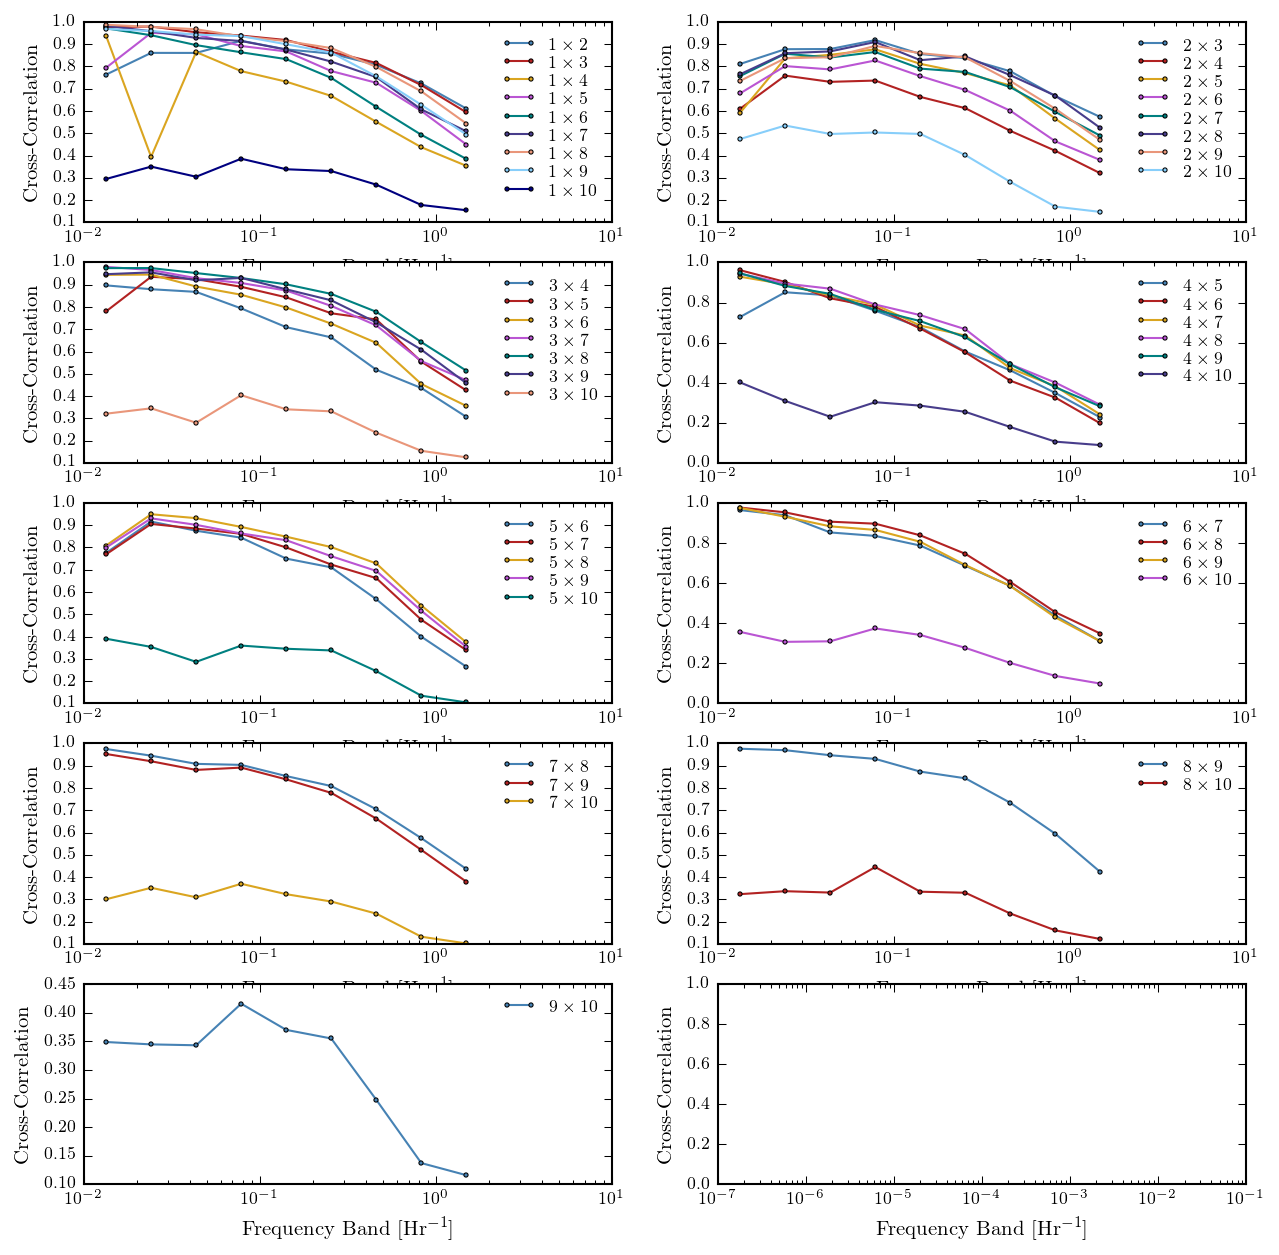

In [71]:

pickle.load(open('../output/bandpassed_cross_correlations.pickle', 'r'))

scan_frequencies = np.logspace(-2,np.log10(2),10)

scan_frequencies_centers = [np.exp(0.5*(np.log(scan_frequencies[i]) + np.log(scan_frequencies[i+1])))
                             for i in range(len(scan_frequencies)-1)]


plt.figure(figsize=(10,10))

for i in range(1,11):
    plt.subplot(5,2,i)
    
    for j, xcorr in enumerate(corr_list[i-1]):        
        plt.plot(scan_frequencies_centers, xcorr, label=r'$%i \times %i$'%(i,j+i+1), marker='o', markersize=2)
    plt.xscale('log')
    plt.xlabel('Frequency Band [Hr$^{-1}$]')
    plt.ylabel('Cross-Correlation')
    plt.legend(loc=1, frameon=False, labelspacing=.2, fontsize=8)
    

## Detecting Anomalous Sensors with power spectral ratios/cross-correlation. 

We plot the sensor power spectral ratio for high/low freqeucny noise ($f>.2$ hr$^{-1}$ versus $f<.2 \rm hr^{-1}$) versus the cross-correlation in a 2D plane, leading to excellent separation between anomalous sensors.


-c:116: ComplexWarning: Casting complex values to real discards the imaginary part


{'snowdepth_1': (0.92506702634772886+0j),
 'snowdepth_10': (99.250571818545779+0j),
 'snowdepth_2': (13.459019905663258+0j),
 'snowdepth_3': (2.274540242313106+0j),
 'snowdepth_4': (3.7131843924386003+0j),
 'snowdepth_5': (10.112026904367646+0j),
 'snowdepth_6': (1.0152150823760719+0j),
 'snowdepth_7': (0.97638305188749419+0j),
 'snowdepth_8': (1.0747183162747169+0j),
 'snowdepth_9': (1.209317501862786+0j)}

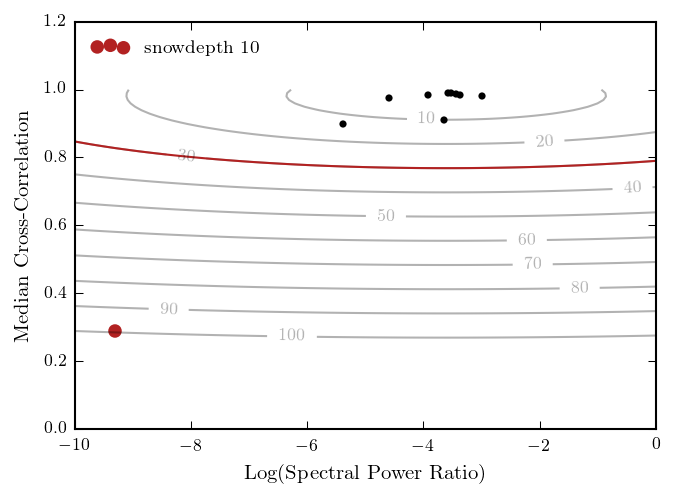

In [95]:
def Power_Spectrum(x, plot=False):
    """Return the power spectrum of the input signal
    
    Input:
        - x: 1d numpy array with input signal
        - plot: If True, plot the power spectrum 
    Output:
        - freq: 1D array with frequencies in inverse hours
        - spec: Power Spectrum
    """
    
    fft_coeff = np.fft.fft(x)
    freq = np.fft.fftfreq(len(x), .25)
    power = fft_coeff*np.conjugate(fft_coeff)
    
    if plot:
        power_filtered = fft_coeff*np.conjugate(fft_coeff)
        plt.loglog(freq, power)
        plt.xlabel('Frequency [Hr$^{-1}$]')
        plt.ylabel(r'Power Spectrum $\langle a_i|a_i \rangle$')
        plt.show()
    return freq, power

def Power_Spectral_Ratio(x, split_freq=.2): 
    """Return the power spectrum of the input signal
    
    Input:
        - x: 1d numpy array with input signal
        - split_freq: Frequency in hr^-1 that defines the split between high/low
    Output:
        -ratio: Power spectral ratio above/below the split freq. 
    """

    freq, power = Power_Spectrum(x) 
    split = np.argmin(np.abs(freq-split_freq))
    
    SPD = freq**2*power # Spectral Power Density is proportional to this for log spaced frequencies.
    
    low_power, high_power = np.sum(power[:split]), np.sum(power[split:])
    return high_power/low_power
    
    
def Cross_Correlation(sig1, sig2): 
    """Return the normalized zero lag cross-correlation
    
    Input:
        - sig1: 1d array with input signal 1 
        - sig2: 1d array with input signal 2 
    Output:
        -xcorr: Cross correlation at zero lag
    """
    # Normalize the input vectors 
    a = (sig1 - mean(sig1)) / (std(sig1) * len(sig1))
    v = (sig2 - mean(sig2)) /  std(sig2)

    corr = signal.correlate(a, v, mode='same')
    return corr[len(a)/2]
    

def DetectAnamolousSensors(df, plot=True, threshold=30):
    """Calculates the mean cross-correlation with other sensors, as well as the noise characteristics of the sensor. 
    
    Input:
        - df: pandas dataframe containing sensor data
        - plot: If true, generate summary plots
        - threshold: modified z-score threshold for detecting an outlier (plotting only)
    Output:
        - sensor_z_scores: dict containing an entry for each sensors modified z-score. 
    """
    
    keys = [column for column in df.columns if 'snowdepth_' in column]
    
    sensor_ratios = {}
    sensor_xcorrs = {}
    sensor_z_scores = {}
    
    for key in keys: 
        # Ratio of high vs low spectral power 
        ratio = np.log(Power_Spectral_Ratio(df[key].values))
        
        # Calculate the mean cross-correlation with all other sensors excluding the autocorrelation 
        mean_xcorr = np.median([Cross_Correlation(df[key].values, df[key2].values) 
                                             for key2 in keys if key2 != key])
        sensor_ratios[key] = ratio
        sensor_xcorrs[key] = mean_xcorr
    
    # Calculate some statistics useful for outliers
    median_xcorr_all = np.median(sensor_xcorrs.values())
    median_ratios_all = np.median(sensor_ratios.values())    
    
    mad_xcorr_all = np.median( np.abs(sensor_xcorrs.values()-median_xcorr_all) )
    mad_ratio_all = np.median( np.abs(sensor_ratios.values()-median_ratios_all) )
    
    def _score_point(ratio, xcorr):
        z1 = (ratio - median_ratios_all)/mad_ratio_all
        z2 = (xcorr - median_xcorr_all)/mad_xcorr_all
        return  np.sqrt(z1**2 + z2**2)
        
    
    # Score each point by quadratically summing the modified z-scores in each dimension 
    for key in keys: 
        sensor_z_scores[key] = _score_point(sensor_ratios[key], sensor_xcorrs[key])
    
    if plot:         
        for key in keys: 
            if sensor_z_scores[key] > threshold: 
                plt.scatter(sensor_ratios[key], sensor_xcorrs[key], 
                            marker='o', s=30, color='firebrick', label=key.replace('_'," "))
            else: 
                plt.scatter(sensor_ratios[key], sensor_xcorrs[key], marker='o', s=6, color='k')
        # Map the decision boundary 
        grid = np.zeros((100,100))
        for i, xcorr in enumerate(np.linspace(0,1,100)):
            ratios = np.linspace(-10,0, 100)
            grid[i] = _score_point(ratios, xcorr)
            
        CS = plt.contour(ratios, np.linspace(0,1,100), grid, levels=np.linspace(0,100,11), colors='k', alpha=.3)
        plt.clabel(CS, inline=1, fontsize=8, fmt='%i')
        CS = plt.contour(ratios, np.linspace(0,1,100), grid, levels=[threshold,], colors='firebrick')
        
        plt.xlabel('Log(Spectral Power Ratio)')
        plt.ylabel('Median Cross-Correlation')
        plt.ylim(0,1.2)
        plt.xlim(-10,0)
        plt.legend(frameon=False, loc=2)
    
    return sensor_z_scores
    
DetectAnamolousSensors(df_clean_filled, threshold=30)
    
    
    

[2]